In [13]:
import os
import torch
import transformers
from transformers import AutoModelWithLMHead, PreTrainedTokenizerFast
from fastai.text.all import *
from tqdm.notebook import tqdm
import fastai
import re

In [2]:
print(torch.__version__)
print(transformers.__version__)
print(fastai.__version__)

1.7.1
4.21.0.dev0
2.2.5


In [24]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
PRETRAINED_MODEL = 'skt/kogpt2-base-v2'
BATCH_SIZE = 8
SEQ_LENGTH = 256
MAX_LENGTH = 128
DATASET_PATH = './dataset/jjaltoon_scripts_10_raw/'

In [4]:
tokenizer = PreTrainedTokenizerFast.from_pretrained(
    PRETRAINED_MODEL,
    unk_token='<unk>',
    pad_token='<pad>',
    mask_token='<mask>',
    bos_token='<s>',
    eos_token='</s>'
)
model = AutoModelWithLMHead.from_pretrained(PRETRAINED_MODEL)

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'GPT2Tokenizer'. 
The class this function is called from is 'PreTrainedTokenizerFast'.
/usr/local/lib/python3.8/dist-packages/transformers/models/auto/modeling_auto.py:969: FutureWarning: The class `AutoModelWithLMHead` is deprecated and will be removed in a future version. Please use `AutoModelForCausalLM` for causal language models, `AutoModelForMaskedLM` for masked language models and `AutoModelForSeq2SeqLM` for encoder-decoder models.
  warnings.warn(


In [5]:
tokenizer.tokenize('GPT-2 토크나이저 테스트. 안녕하세요.')

['▁G',
 'P',
 'T',
 '-2',
 '▁토크',
 '나이',
 '저',
 '▁테',
 '스트',
 '.',
 '▁안녕',
 '하',
 '세',
 '요.']

In [7]:
text = '오늘의 메뉴는'
input_ids = tokenizer.encode(text)
gen_ids = model.generate(
    torch.tensor([input_ids]),
    max_length=MAX_LENGTH,
    repetition_penalty=2.0,
    pad_token_id=tokenizer.pad_token_id,
    bos_token_id=tokenizer.bos_token_id,
    eos_token_id=tokenizer.eos_token_id,
    use_cache=True
)
generated = tokenizer.decode(gen_ids[0,:].tolist())
generated

'오늘의 메뉴는 ‘치킨’. 치즈에 햄을 넣어 만든 소스다.\n이렇게 해서 나온 것이 바로 닭가슴살이다.\n닭 가슴살은 육질이 부드럽고 담백해 남녀노소 누구나 좋아하는 음식 중 하나다.\n특히, 이번에 선보인 신메일은 국내산 돼지고기를 사용해 더욱 고소하고 부드러운 맛을 느낄 수 있다.\n또한 양파, 마늘 등 야채와 함께 곁들여 먹으면 더 맛있게 먹을 수도 있다.</d> 지난달 30일 서울 강남구 삼성동 코엑스에서 열린 \'2018 대한민국 디자인대상\' 시상식에서 한국디자인진흥원이 주최하는 이번 공모전은 총 330여점의 작품이 접수됐다.\n심사위원단은 "한국'

In [16]:
texts = []

file_names = os.listdir(DATASET_PATH)
for file_name in tqdm(file_names, desc='input data files'):
    file_path = os.path.join(DATASET_PATH, file_name)
    with open(file_path, mode='r', encoding='utf-8') as file:
        file_content = file.read()
    texts.append(' '.join(file_content.split()))

data = ' '.join(texts)
len(data)

input data files:   0%|          | 0/10 [00:00<?, ?it/s]

47854

In [19]:
# Normalization
#data = re.sub('\(계속\).*?[●○]', '', data)
#data = re.sub('[●○]', '', data)
#len(data)

In [20]:
class TransformersTokenizer(Transform):
    def __init__(self, tokenizer):
        self.tokenizer = tokenizer
    
    def encodes(self, x):
        tokens = self.tokenizer.tokenize(x)
        return tensor(self.tokenizer.convert_tokens_to_ids(tokens))
    
    def decodes(self, x):
        return TitledStr(self.tokenizer.decode(x.cpu().numpy()))

In [22]:
train_data = data[:int(len(data) * 0.9)]
test_data = data[int(len(data) * 0.9):]
splits = [[0], [1]]

In [26]:
tls = TfmdLists([train_data, test_data], TransformersTokenizer(tokenizer), splits=splits, dl_type=LMDataLoader)
dls = tls.dataloaders(bs=BATCH_SIZE, seq_len=SEQ_LENGTH)
dls.show_batch(max_n=2)

/usr/local/lib/python3.8/dist-packages/fastai/torch_core.py:458: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ax = ax.append(pd.Series({label: o}))
/usr/local/lib/python3.8/dist-packages/fastai/torch_core.py:458: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ax = ax.append(pd.Series({label: o}))
/usr/local/lib/python3.8/dist-packages/fastai/torch_core.py:458: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ax = ax.append(pd.Series({label: o}))
/usr/local/lib/python3.8/dist-packages/fastai/torch_core.py:458: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ax = ax.append(pd.Series({label: o}))


,text,text_
0,"짐승친구들 6화 외계인 할일 없어보이는 짐승친구들이 집안에서 각자의 방식으로 뒹굴거리고 있다. 땅땅이 : 노트북 고장나서 할 것도 없고... 너무 너무 심심한 것입니땅!!!!! 김현식 : 올만에 다같이 피방이나 ᄀ? 슘<unk>이 : 우리가 피방 갈 돈이 어<unk>슘<unk>... 땅땅이 : 집사 지갑을 한번 뒤져봅씨땅!!!!!!! <unk> 수민의 지갑에 포스트잇으로 ‘건드리면 중성화 수술’이라고 붙어있다. 땅땅이 :......지갑은 안건드리는 게 좋겠습니땅 김현식 : 뭐 재밌는 거 없나...? 슘<unk>이 : 하늘에서 컴퓨터라도 한대 떨어졌으면 좋겠슘<unk>.... ----- 갑자기 창문이 와장창 깨지며 집 안으로 컴퓨터 한대가 날아와 새대갈의 머리를 강타한다. 머리에 큰 혹을 달고 기절한 새대갈과 그 옆에 떨어져있는 컴퓨터. 땅땅이, 슘<unk>이, 현식이 : 에에에엣!?!?! (현식이는 팻말로) 땅땅이 : 괘,괜찮습니깡!? 어디 다친데 없습니","친구들 6화 외계인 할일 없어보이는 짐승친구들이 집안에서 각자의 방식으로 뒹굴거리고 있다. 땅땅이 : 노트북 고장나서 할 것도 없고... 너무 너무 심심한 것입니땅!!!!! 김현식 : 올만에 다같이 피방이나 ᄀ? 슘<unk>이 : 우리가 피방 갈 돈이 어<unk>슘<unk>... 땅땅이 : 집사 지갑을 한번 뒤져봅씨땅!!!!!!! <unk> 수민의 지갑에 포스트잇으로 ‘건드리면 중성화 수술’이라고 붙어있다. 땅땅이 :......지갑은 안건드리는 게 좋겠습니땅 김현식 : 뭐 재밌는 거 없나...? 슘<unk>이 : 하늘에서 컴퓨터라도 한대 떨어졌으면 좋겠슘<unk>.... ----- 갑자기 창문이 와장창 깨지며 집 안으로 컴퓨터 한대가 날아와 새대갈의 머리를 강타한다. 머리에 큰 혹을 달고 기절한 새대갈과 그 옆에 떨어져있는 컴퓨터. 땅땅이, 슘<unk>이, 현식이 : 에에에엣!?!?! (현식이는 팻말로) 땅땅이 : 괘,괜찮습니깡!? 어디 다친데 없습니깡"
1,비켜라.... 땅땅이 : 우리도 지금 굉장히 중요한 작업하고 있는 거 안보입니깡!? 전체적인 풀샷이 잡히면서 노트북에서 개가 짝짓기 하는 장면이 나온다 수민 : 짝짓기 영상 보는게 중요한 작업이냐? 이 변태새끼들아? 김현식 : 형 우리가 뭐 이런거 자주 보는 것도 아니고 이해 좀 해줘 수민 : 하루에 일곱번씩 기본 5시간 보는게 자주 보는게 아니면 대체 얼마나 봐야 자주 보는 거냐? 이 시바견아 땅땅이 : 아무튼 우리 해피 타임 아직 안끝났으니까 끝날 때까지 기다리십씨오!!!!!!!!! (현식에게)그리고 찌발럼아 이제 고양이 짝짓기 영상 좀 봅씨땅!!!!!!!!!! 언제까지 개쌔끼들 하는 것만 봐야됩니깡!? 김현식 : 진짜 딱 10분만 더 보자 ᄅᄋ 땅땅이 : 그렇게 10분만 더 보자 보자 한 게 벌써 2시간 <unk>니땅 개찌발련아! 수민 : (잠시 땅땅이와 현식이를 째려보다가 뭔가를 결심한 듯).......휴 안되겠다...! 아무래도 내가 니,켜라.... 땅땅이 : 우리도 지금 굉장히 중요한 작업하고 있는 거 안보입니깡!? 전체적인 풀샷이 잡히면서 노트북에서 개가 짝짓기 하는 장면이 나온다 수민 : 짝짓기 영상 보는게 중요한 작업이냐? 이 변태새끼들아? 김현식 : 형 우리가 뭐 이런거 자주 보는 것도 아니고 이해 좀 해줘 수민 : 하루에 일곱번씩 기본 5시간 보는게 자주 보는게 아니면 대체 얼마나 봐야 자주 보는 거냐? 이 시바견아 땅땅이 : 아무튼 우리 해피 타임 아직 안끝났으니까 끝날 때까지 기다리십씨오!!!!!!!!! (현식에게)그리고 찌발럼아 이제 고양이 짝짓기 영상 좀 봅씨땅!!!!!!!!!! 언제까지 개쌔끼들 하는 것만 봐야됩니깡!? 김현식 : 진짜 딱 10분만 더 보자 ᄅᄋ 땅땅이 : 그렇게 10분만 더 보자 보자 한 게 벌써 2시간 <unk>니땅 개찌발련아! 수민 : (잠시 땅땅이와 현식이를 째려보다가 뭔가를 결심한 듯).......휴 안되겠다...! 아무래도 내가 니들


In [27]:
class DropOutput(Callback):
    def after_pred(self):
        self.learn.pred = self.pred[0]

SuggestedLRs(lr_min=0.012022644281387329, lr_steep=0.10000000149011612)


AssertionError: Trying to set 2 values for lr but there are 1 parameter groups.

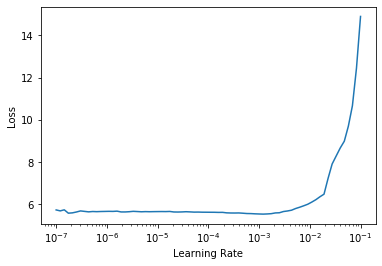

In [32]:
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), cbs=[DropOutput], metrics=Perplexity()).to_fp16()
lr = learn.lr_find()
print(lr)
learn.fit_one_cycle(5, lr)

SuggestedLRs(lr_min=0.012022644281387329, lr_steep=0.10000000149011612)


epoch,train_loss,valid_loss,perplexity,time
0,5.744494,7.156295,1282.152100,00:03
1,5.674646,6.628106,756.048950,00:03
2,5.409163,6.447110,630.876526,00:03
3,5.129766,6.497020,663.162598,00:03
4,4.868250,6.421448,614.892700,00:03


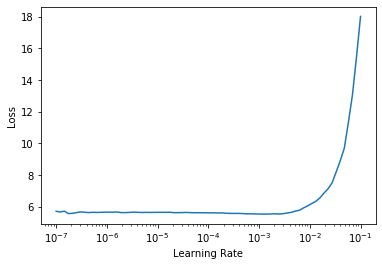

In [34]:
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat(), cbs=[DropOutput], metrics=Perplexity()).to_fp16()
lr = learn.lr_find()
print(lr)
learn.fit_one_cycle(n_epoch=5)

In [41]:
prompt = '땅땅이'
prompt_ids = tokenizer.encode(prompt)
inp = tensor(prompt_ids)[None].cuda()
preds = learn.model.generate(
    inp,
    pad_token_id=tokenizer.pad_token_id,
    bos_token_id=tokenizer.bos_token_id,
    eos_token_id=tokenizer.eos_token_id,
    use_cache=True
)
tokenizer.decode(preds[0].cpu().numpy())

'땅땅이 : (그,그,그,그,그고) (그구 :'

In [43]:
#learn.model.save_pretrained('kogpt2novel_backup')
#model.push_to_hub('kogpt2novel')
#tokenizer.push_to_hub('kogpt2novel')